# Intel Image Classification

In [6]:
!pip install tensorflow keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import cv2
import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
import os

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

from random import randint
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras import layers
from tensorflow.keras import Model, Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator


print(tf.__version__)

2.11.0


In [ ]:
BATCH_SIZE = 25
EPOCHS = 10
IMAGE_SIZE = (350, 350)


# Get device name (GPU)

In [ ]:
device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
print('Found GPU at: {}'.format(device_name))

GPU device not found
Found GPU at: 


# Let's see the available folders

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Dataset'):
    print(dirname)

/content/drive/MyDrive/Dataset
/content/drive/MyDrive/Dataset/Test
/content/drive/MyDrive/Dataset/Test/cataract
/content/drive/MyDrive/Dataset/Test/glaucoma
/content/drive/MyDrive/Dataset/Test/normal
/content/drive/MyDrive/Dataset/Test/retinaldiseases
/content/drive/MyDrive/Dataset/Train
/content/drive/MyDrive/Dataset/Train/cataract
/content/drive/MyDrive/Dataset/Train/glaucoma
/content/drive/MyDrive/Dataset/Train/normal
/content/drive/MyDrive/Dataset/Train/retinaldiseases
/content/drive/MyDrive/Dataset/Pred


# Define classes

In [ ]:
CLASSES = {'normal': 0, 'cataract': 1, 'glaucoma': 2, 'retinaldiseases': 3}

# Get Train Sample

In [ ]:
def shuffle_prune(df, BATCH_SIZE):
    df = shuffle(df, random_state=42)
    df.reset_index(drop=True, inplace=True)
    df = df[ : df.shape[0] // BATCH_SIZE * BATCH_SIZE]
    return df

In [ ]:
filenames = tf.io.gfile.glob('/content/drive/MyDrive/Dataset/Train/*/*')
image_path_df_train = pd.DataFrame(data={'filename': filenames, 'class': [x.split('/')[-2] for x in filenames]})
image_path_df_train = shuffle_prune(image_path_df_train, BATCH_SIZE)
image_path_df_train['class'] = image_path_df_train['class'].map(CLASSES)

print('Train sample: ', len(image_path_df_train['class']), dict(image_path_df_train['class'].value_counts()))

Train sample:  475 {0: 237, 2: 81, 3: 79, 1: 78}


# Get Test Sample

In [ ]:
filenames = tf.io.gfile.glob('/content/drive/MyDrive/Dataset/Test/*/*')
image_path_df_test = pd.DataFrame(data={'filename': filenames, 'class': [x.split('/')[-2] for x in filenames]})

print('Test sample: ', len(image_path_df_test['class']), dict(image_path_df_test['class'].value_counts()))

Test sample:  120 {'normal': 60, 'cataract': 20, 'retinaldiseases': 20, 'glaucoma': 20}


# Get Validation sample from test sample

In [ ]:
image_path_df_test, image_path_df_val  = train_test_split(image_path_df_test, test_size=0.5, random_state=42, stratify=image_path_df_test['class'])
image_path_df_test = shuffle_prune(image_path_df_test, BATCH_SIZE)
image_path_df_test['class'] = image_path_df_test['class'].map(CLASSES)

image_path_df_val = shuffle_prune(image_path_df_val, BATCH_SIZE)
image_path_df_val['class'] = image_path_df_val['class'].map(CLASSES)

print('Test sample: ', len(image_path_df_test['class']), dict(image_path_df_test['class'].value_counts()))
print('Val  sample: ', len(image_path_df_val['class']), dict(image_path_df_val['class'].value_counts()))

Test sample:  50 {0: 24, 2: 10, 1: 9, 3: 7}
Val  sample:  50 {0: 26, 1: 9, 2: 8, 3: 7}


# Get files for prediction

In [ ]:
filenames = tf.io.gfile.glob('/content/drive/MyDrive/Dataset/Pred/*')

image_path_df_predict = pd.DataFrame(data={'filename': filenames, 'class': np.nan})
print(f'Number filenames: {len(image_path_df_predict)}')

Number filenames: 601


# Get arrays and labels

In [ ]:
def get_images_and_labels_arrays(df):
    images = []
    for file in df['filename']:
        image = cv2.imread(file)
        image = cv2.resize(image,IMAGE_SIZE)
        images.append(image)
    images = np.array(images)
    
    labels = df.loc[:, 'class']
    return images, labels

In [ ]:
train_images, train_labels = get_images_and_labels_arrays(image_path_df_train)

print(f'Shape of train set: {train_images.shape}')
print(f'Shape of train set: {train_labels.shape}')

Shape of train set: (475, 350, 350, 3)
Shape of train set: (475,)


In [ ]:
val_images, val_labels = get_images_and_labels_arrays(image_path_df_val)

print(f'Shape of validation set: {val_images.shape}')
print(f'Shape of validation set: {val_labels.shape}')

Shape of validation set: (50, 350, 350, 3)
Shape of validation set: (50,)


In [ ]:
test_images, test_labels = get_images_and_labels_arrays(image_path_df_test)

print(f'Shape of test set: {test_images.shape}')
print(f'Shape of test set: {test_labels.shape}')

Shape of test set: (50, 350, 350, 3)
Shape of test set: (50,)


# We have 4 classes in this work like this

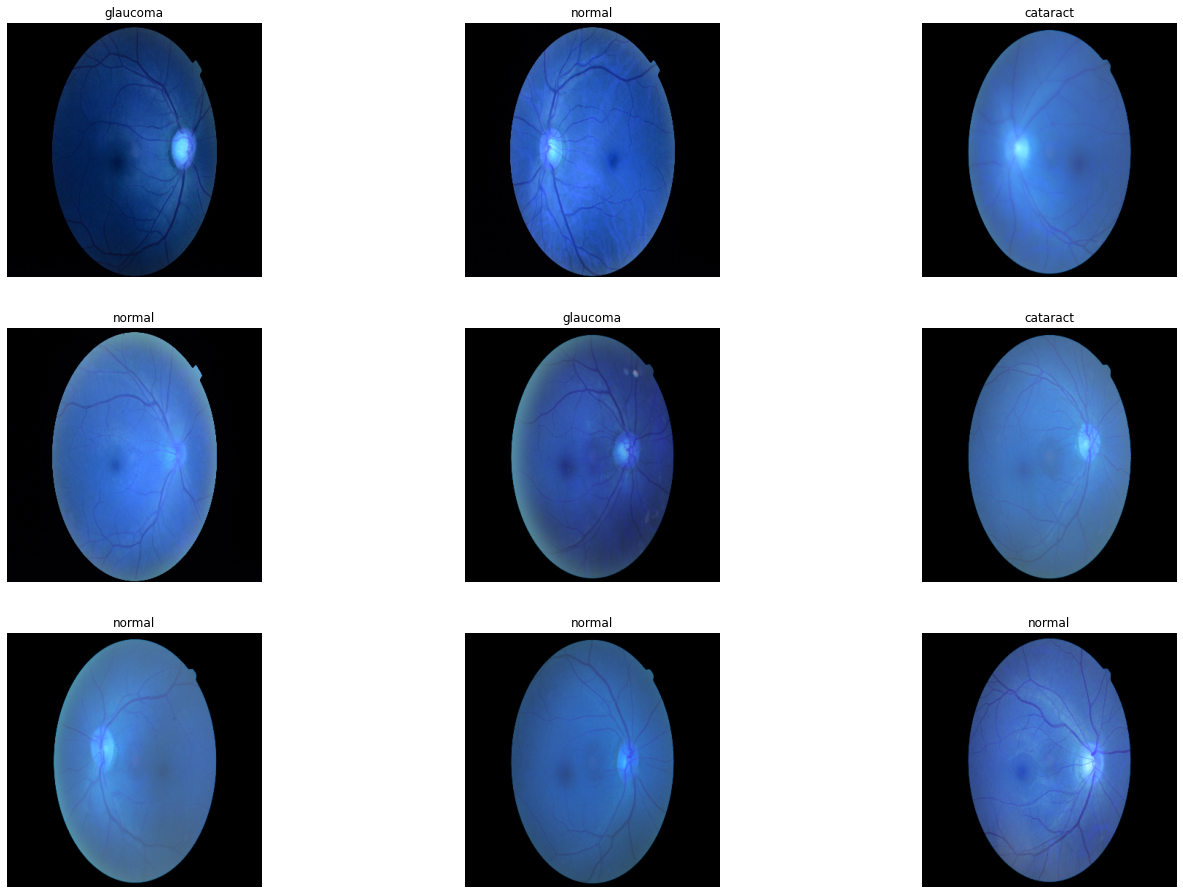

In [ ]:
f,ax = plt.subplots(3,3) 
f.subplots_adjust(0,0,3,3)
for i in range(0,3,1):
    for j in range(0,3,1):
        rnd_number = randint(0,len(train_images))
        ax[i,j].imshow(train_images[rnd_number])
        ax[i,j].set_title([key for key, val in CLASSES.items() if val == train_labels[rnd_number]][0])
        ax[i,j].axis('off')

# Define CNN Keras model and compile

In [ ]:
def create_model():
    
    with tf.device('/gpu:0'):
    
        input_layer = layers.Input(shape=(*IMAGE_SIZE, 3), name='input') 
        x = layers.BatchNormalization()(input_layer)

        x = layers.Conv2D(filters=64, kernel_size=3, 
                          activation='relu', padding='same', 
                          name='conv2d_1')(x)
        x = layers.MaxPool2D(pool_size=2, name='maxpool2d_1')(x)
        x = layers.Dropout(0.1, name='dropout_1')(x)

        x = layers.Conv2D(filters=128, kernel_size=3, 
                          activation='relu', padding='same', 
                          name='conv2d_2')(x)
        x = layers.MaxPool2D(pool_size=2, name='maxpool2d_2')(x)
        x = layers.Dropout(0.1, name='dropout_2')(x)

        x = layers.Conv2D(filters=256, kernel_size=3, 
                          activation='relu', padding='same', 
                          name='conv2d_3')(x)
        x = layers.MaxPool2D(pool_size=2, name='maxpool2d_3')(x)
        x = layers.Dropout(0.1, name='dropout_3')(x)

        x = layers.Conv2D(filters=512, kernel_size=3, 
                          activation='relu', padding='same', 
                          name='conv2d_4')(x)
        x = layers.MaxPool2D(pool_size=2, name='maxpool2d_4')(x)
        x = layers.Dropout(0.1, name='dropout_4')(x)

        x = layers.Conv2D(filters=1024, kernel_size=3, 
                          activation='relu', padding='same', 
                          name='conv2d_5')(x)
        x = layers.MaxPool2D(pool_size=2, name='maxpool2d_5')(x)
        x = layers.Dropout(0.1, name='dropout_5')(x)
        

        x = layers.GlobalAveragePooling2D(name='global_average_pooling2d')(x)
        x = layers.BatchNormalization()(x)
       
        x = layers.Dense(128,activation='relu')(x)
        
        output = layers.Dense(units=len(CLASSES), 
                              activation='softmax', 
                              name='output')(x)


        model = Model (input_layer, output)    
        model.compile(optimizer='adam', 
                      loss='sparse_categorical_crossentropy', 
                      metrics=['accuracy'])

    return model

model = create_model()
model.summary()

Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 350, 350, 3)]     0         
                                                                 
 batch_normalization_33 (Bat  (None, 350, 350, 3)      12        
 chNormalization)                                                
                                                                 
 conv2d_1 (Conv2D)           (None, 350, 350, 64)      1792      
                                                                 
 maxpool2d_1 (MaxPooling2D)  (None, 175, 175, 64)      0         
                                                                 
 dropout_1 (Dropout)         (None, 175, 175, 64)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 175, 175, 128)     73856     
                                                          

# Run model training

In [ ]:
init_time = datetime.datetime.now()
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 1, verbose=1, factor=0.3, min_lr=0.000001)

trained = model.fit(
                    train_images, train_labels,
                    validation_data = (val_images, val_labels),
                    batch_size = BATCH_SIZE, 
                    epochs=EPOCHS,
                    callbacks=[learning_rate_reduction],
    )

requared_time = datetime.datetime.now() - init_time
print(f'\nRequired time:  {str(requared_time)}\n')

Epoch 1/10
19/19 [==============================] - 16s 521ms/step - loss: 1.6256 - accuracy: 0.4000 - val_loss: 17.2986 - val_accuracy: 0.5200 - lr: 0.0010
Epoch 2/10
19/19 [==============================] - ETA: 0s - loss: 1.3363 - accuracy: 0.4968
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
19/19 [==============================] - 9s 493ms/step - loss: 1.3363 - accuracy: 0.4968 - val_loss: 6.0816 - val_accuracy: 0.4200 - lr: 0.0010
Epoch 3/10
19/19 [==============================] - ETA: 0s - loss: 1.2049 - accuracy: 0.5221
Epoch 3: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
19/19 [==============================] - 9s 494ms/step - loss: 1.2049 - accuracy: 0.5221 - val_loss: 6.6942 - val_accuracy: 0.5200 - lr: 3.0000e-04
Epoch 4/10
19/19 [==============================] - ETA: 0s - loss: 1.1171 - accuracy: 0.5621
Epoch 4: ReduceLROnPlateau reducing learning rate to 2.700000040931627e-05.
19/19 [==============================] - 

# Training process

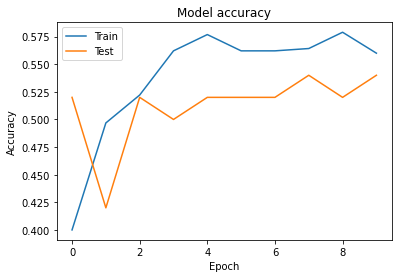

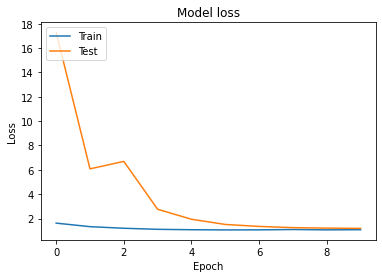

In [ ]:
plt.plot(trained.history['accuracy'])
plt.plot(trained.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(trained.history['loss'])
plt.plot(trained.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Evaluate the trained model

In [ ]:
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=0)
print('accuracy:', test_acc, '  loss: ',test_loss)

accuracy: 0.5400000214576721   loss:  1.2707654237747192


# Prediction

In [ ]:
predict = np.argmax(model.predict(test_images), axis=1)
predict

2/2 [==============================] - 0s 112ms/step


array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

# Classification report & confusion matrix

              precision    recall  f1-score   support

           0       0.56      1.00      0.72        24
           1       0.43      0.33      0.38         9
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00         7

    accuracy                           0.54        50
   macro avg       0.25      0.33      0.27        50
weighted avg       0.35      0.54      0.41        50
 



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


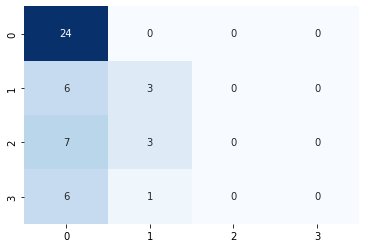

In [ ]:
print(classification_report(test_labels, predict), '\n')
cm = confusion_matrix(test_labels, predict)
sns.heatmap(cm, annot=True, cmap="Blues", fmt='.0f', cbar=False)
plt.show()

# Let's try pretrained model for example VGG19

In [ ]:
def create_model():
    with tf.device('/gpu:0'):
        pretrained_model = tf.keras.applications.VGG19(
            weights='imagenet',
            include_top=False ,
            input_shape=[*IMAGE_SIZE, 3]
        )
        pretrained_model.trainable = False

        
        
        input_layer = layers.Input(shape=(*IMAGE_SIZE, 3), name='input') 
        
        x = pretrained_model(input_layer)

        x = layers.GlobalAveragePooling2D(name='global_average_pooling2d')(x)
        x = layers.BatchNormalization()(x)       
        x = layers.Dense(128,activation='relu')(x)

        
        output = layers.Dense(units=len(CLASSES), 
                              activation='softmax', 
                              name='output')(x)


        model = Model (input_layer, output)    
        model.compile(optimizer='adam', 
                      loss='sparse_categorical_crossentropy', 
                      metrics=['accuracy'])

        return model

model = create_model()
model.summary()

Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 350, 350, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, 10, 10, 512)       20024384  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization_35 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 dense_20 (Dense)            (None, 128)               65664     
                                                                 
 output (Dense)              (None, 4)                 516

In [ ]:
init_time = datetime.datetime.now()
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 1, verbose=1, factor=0.3, min_lr=0.000001)

trained = model.fit(
                    train_images, train_labels,
                    validation_data = (val_images, val_labels),
                    batch_size = BATCH_SIZE, 
                    epochs=EPOCHS,
                    callbacks=[learning_rate_reduction],
    )

requared_time = datetime.datetime.now() - init_time
print(f'\nRequired time:  {str(requared_time)}\n')

Epoch 1/10
19/19 [==============================] - 12s 404ms/step - loss: 1.2048 - accuracy: 0.5158 - val_loss: 1.9631 - val_accuracy: 0.5200 - lr: 0.0010
Epoch 2/10
19/19 [==============================] - 7s 394ms/step - loss: 0.6382 - accuracy: 0.7621 - val_loss: 1.6044 - val_accuracy: 0.5400 - lr: 0.0010
Epoch 3/10
19/19 [==============================] - 7s 361ms/step - loss: 0.4241 - accuracy: 0.8568 - val_loss: 1.3244 - val_accuracy: 0.5800 - lr: 0.0010
Epoch 4/10
19/19 [==============================] - 8s 400ms/step - loss: 0.3185 - accuracy: 0.9179 - val_loss: 1.2430 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 5/10
19/19 [==============================] - ETA: 0s - loss: 0.2282 - accuracy: 0.9516
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
19/19 [==============================] - 7s 371ms/step - loss: 0.2282 - accuracy: 0.9516 - val_loss: 1.0661 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 6/10
19/19 [==============================] - 8s 413ms/step

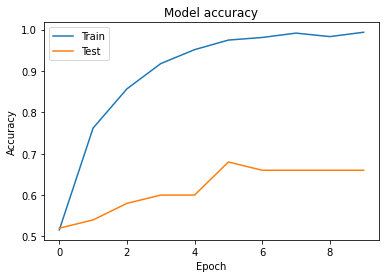

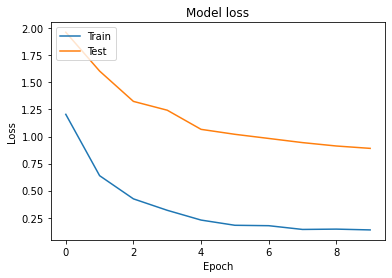

In [ ]:
plt.plot(trained.history['accuracy'])
plt.plot(trained.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(trained.history['loss'])
plt.plot(trained.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=0)
print('\naccuracy:', test_acc, '  loss: ',test_loss)


accuracy: 0.6200000047683716   loss:  1.0680170059204102


# Prediction

In [ ]:
predict = np.argmax(model.predict(test_images), axis=1)
predict

2/2 [==============================] - 0s 238ms/step


array([0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 3, 0, 2, 3, 1, 3, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 1, 0, 0, 1,
       3, 0, 0, 1, 0, 0, 0, 0, 3, 1, 0, 0, 0, 0, 0, 3])

# Classification report & confusion matrix

              precision    recall  f1-score   support

           0       0.63      0.90      0.74        30
           1       0.57      0.40      0.47        10
           2       1.00      0.40      0.57        10
           3       0.67      0.40      0.50        10

    accuracy                           0.65        60
   macro avg       0.72      0.53      0.57        60
weighted avg       0.69      0.65      0.63        60
 



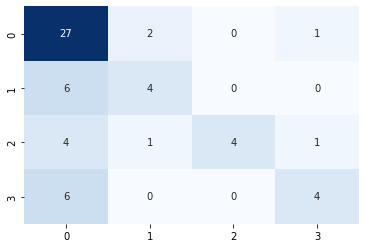

In [ ]:
print(classification_report(test_labels, predict), '\n')
cm = confusion_matrix(test_labels, predict)
sns.heatmap(cm, annot=True, cmap="Blues", fmt='.0f', cbar=False)
plt.show()

# Let's predict unlabeled images

In [ ]:
to_predict_images, to_predict_labels = get_images_and_labels_arrays(image_path_df_predict)
print(f'Shape of images set to prediction: {to_predict_images.shape}')

Shape of images set to prediction: (601, 250, 250, 3)


In [ ]:
predict = np.argmax(model.predict(to_predict_images), axis=1)
predict

19/19 [==============================] - 3s 188ms/step


array([1, 3, 1, 1, 2, 3, 2, 0, 0, 0, 0, 3, 0, 0, 0, 3, 2, 2, 0, 3, 1, 0,
       0, 0, 2, 1, 3, 2, 0, 2, 0, 1, 0, 0, 0, 0, 0, 1, 0, 2, 3, 1, 0, 0,
       0, 0, 3, 3, 1, 0, 2, 0, 0, 3, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 3, 3, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 3, 0, 3, 3, 0, 1, 1, 0, 2, 3, 0, 0, 0, 0, 0, 2, 2, 3, 2, 0, 0,
       0, 0, 0, 2, 2, 0, 2, 0, 0, 1, 3, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2, 0,
       2, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 3, 0, 0, 0, 0, 0, 0,
       1, 0, 3, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 3, 0, 1, 0, 0, 3, 1, 1,
       3, 0, 3, 0, 1, 0, 0, 0, 0, 1, 2, 2, 0, 0, 1, 1, 0, 0, 0, 0, 3, 2,
       0, 1, 0, 0, 0, 1, 3, 0, 3, 0, 2, 0, 3, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 2, 0, 0, 2, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 3,
       0, 0, 1, 0, 0, 0, 2, 0, 0, 2, 2, 2, 0, 3, 3, 0, 3, 2, 1, 0, 3, 0,
       1, 0, 0, 0, 0, 0, 2, 0, 0, 3, 2, 0, 1, 2, 3, 0, 3, 0, 0, 3, 0, 3,
       2, 0, 0, 1, 0, 2, 2, 0, 0, 0, 0, 0, 3, 0, 1,

# Let's check random images

In [ ]:
f,ax = plt.subplots(5,5) 
f.subplots_adjust(0,0,3,3)
for i in range(0,5,1):
    for j in range(0,5,1):
        rnd_number = randint(0,len(predict))
        ax[i,j].imshow(to_predict_images[rnd_number])
        ax[i,j].set_title([key for key, val in CLASSES.items() if val == predict[rnd_number]][0])
        ax[i,j].axis('off')

**Testing**

In [ ]:
filenames = tf.io.gfile.glob('/content/drive/MyDrive/singleInput/*')

image_path_df_predict = pd.DataFrame(data={'filename': filenames, 'class': np.nan})
print(f'Number filenames: {len(image_path_df_predict)}')
print(filenames)

Number filenames: 4
['/content/drive/MyDrive/singleInput/cataract_068.png', '/content/drive/MyDrive/singleInput/Glaucoma_010.png', '/content/drive/MyDrive/singleInput/Retina_095.png', '/content/drive/MyDrive/singleInput/NL_012.png']


In [ ]:
to_predict_images, to_predict_labels = get_images_and_labels_arrays(image_path_df_predict)

In [ ]:
predict = np.argmax(model.predict(to_predict_images), axis=1)
predict

1/1 [==============================] - 0s 26ms/step


array([1, 2, 3, 0])

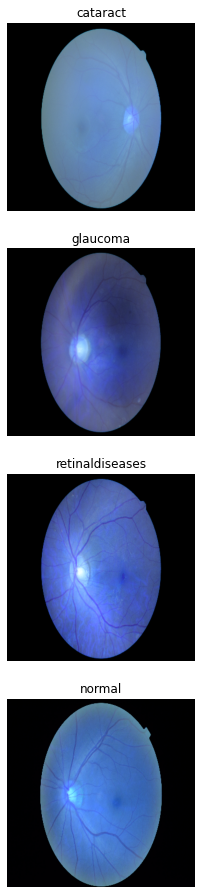

In [ ]:
f,ax = plt.subplots(len(predict)) 
f.subplots_adjust(0,0,3,3)
i = 0
for j in range(0,len(predict),1):
    ax[j].imshow(to_predict_images[j])
    ax[j].set_title([key for key, val in CLASSES.items() if val == predict[j]][0])
    ax[j].axis('off')